In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#Data paths
data_dir_train = 'data/Training data'
data_dir_val = 'data/Validation data'
data_dir_test = 'data/Test data'
#Module parametres
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_val,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)

Found 6238 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Found 977 files belonging to 4 classes.
['Elephant', 'Panda', 'Tiger', 'Zebra']


In [2]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#Standarize data
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [3]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [4]:
num_classes = len(class_names)

model = Sequential([
 # layers.BatchNormalization(input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [5]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [6]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
195/195 [==============================] - 71s 359ms/step - loss: 1.0428 - accuracy: 0.6032 - val_loss: 0.9567 - val_accuracy: 0.5875
Epoch 2/15
195/195 [==============================] - 69s 356ms/step - loss: 0.6299 - accuracy: 0.7536 - val_loss: 0.8346 - val_accuracy: 0.6925
Epoch 3/15
195/195 [==============================] - 68s 348ms/step - loss: 0.5164 - accuracy: 0.8057 - val_loss: 1.8436 - val_accuracy: 0.5400
Epoch 4/15
195/195 [==============================] - 68s 347ms/step - loss: 0.4529 - accuracy: 0.8254 - val_loss: 0.7843 - val_accuracy: 0.7425
Epoch 5/15
195/195 [==============================] - 70s 361ms/step - loss: 0.4115 - accuracy: 0.8500 - val_loss: 1.1752 - val_accuracy: 0.6750
Epoch 6/15
195/195 [==============================] - 69s 351ms/step - loss: 0.3806 - accuracy: 0.8602 - val_loss: 0.7374 - val_accuracy: 0.7875
Epoch 7/15
195/195 [==============================] - 68s 347ms/step - loss: 0.3566 - accuracy: 0.8714 - val_loss: 0.8751 - val_ac

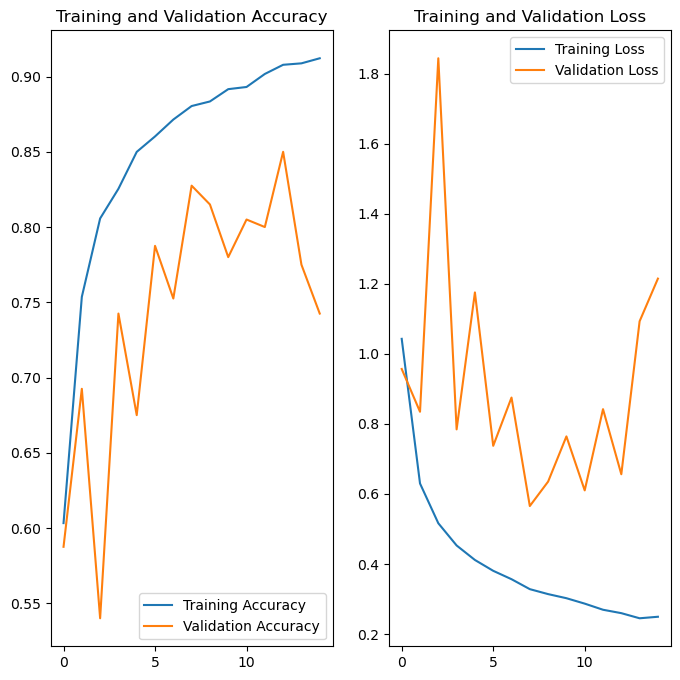

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [8]:
#Testing model on test data
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy:', accuracy)


31/31 [==============================] - 3s 81ms/step - loss: 1.5100 - accuracy: 0.7584
Test accuracy: 0.7584441900253296


In [9]:
model.save('model4r.h5')